<a href="https://colab.research.google.com/github/Ash2809/Sales_Forecasting/blob/main/Sales_Forecast_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [118]:
stores_df = pd.read_csv("/content/drive/MyDrive/Sales Forecasting /stores data-set.csv")
sales_df = pd.read_csv("/content/drive/MyDrive/Sales Forecasting /sales data-set.csv")
features_df = pd.read_csv("/content/drive/MyDrive/Sales Forecasting /Features data set.csv")

In [119]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [120]:
sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [121]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [122]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [114]:
features_df.isnull().sum()

,0
Store,0
Date,0
Temperature,0
Fuel_Price,0
MarkDown1,4158
MarkDown2,5269
MarkDown3,4577
MarkDown4,4726
MarkDown5,4140
CPI,585


In [115]:
features_df.shape

(8190, 12)

# **Data Preprocessing, Wrangling & Feature Eng**

In [123]:
sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%d/%m/%Y')
features_df['Date'] = pd.to_datetime(features_df['Date'], format='%d/%m/%Y')

In [124]:
df = sales_df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
df = df.merge(stores_df, on='Store', how='left')

In [125]:
df = sales_df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
df = df.merge(stores_df, on='Store', how='left')

In [126]:
markdowns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdowns] = df[markdowns].fillna(0)

In [127]:
# Feature Engineering
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Year'] = df['Date'].dt.year

In [128]:
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

# Convert Date
df['date'] = pd.to_datetime(df['date'])

markdown_cols = ['markdown1', 'markdown2', 'markdown3', 'markdown4', 'markdown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

# Creating derived features
df['is_weekend'] = df['date'].dt.dayofweek >= 5
df['quarter'] = df['date'].dt.quarter
df['markdown_total'] = df[markdown_cols].sum(axis=1)
df['sales_per_sqft'] = df['weekly_sales'] / df['size']

df['isholiday'] = df['isholiday'].astype(bool)

df.drop_duplicates(inplace=True)

df = df[df['weekly_sales'] >= 0]

In [130]:
df.head()

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,...,unemployment,type,size,month,week,year,is_weekend,quarter,markdown_total,sales_per_sqft
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,2,5,2010,False,1,0.0,0.164719
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,8.106,A,151315,2,6,2010,False,1,0.0,0.304263
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,8.106,A,151315,2,7,2010,False,1,0.0,0.274894
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,8.106,A,151315,2,8,2010,False,1,0.0,0.128233
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,8.106,A,151315,3,9,2010,False,1,0.0,0.144255


# **EDA**

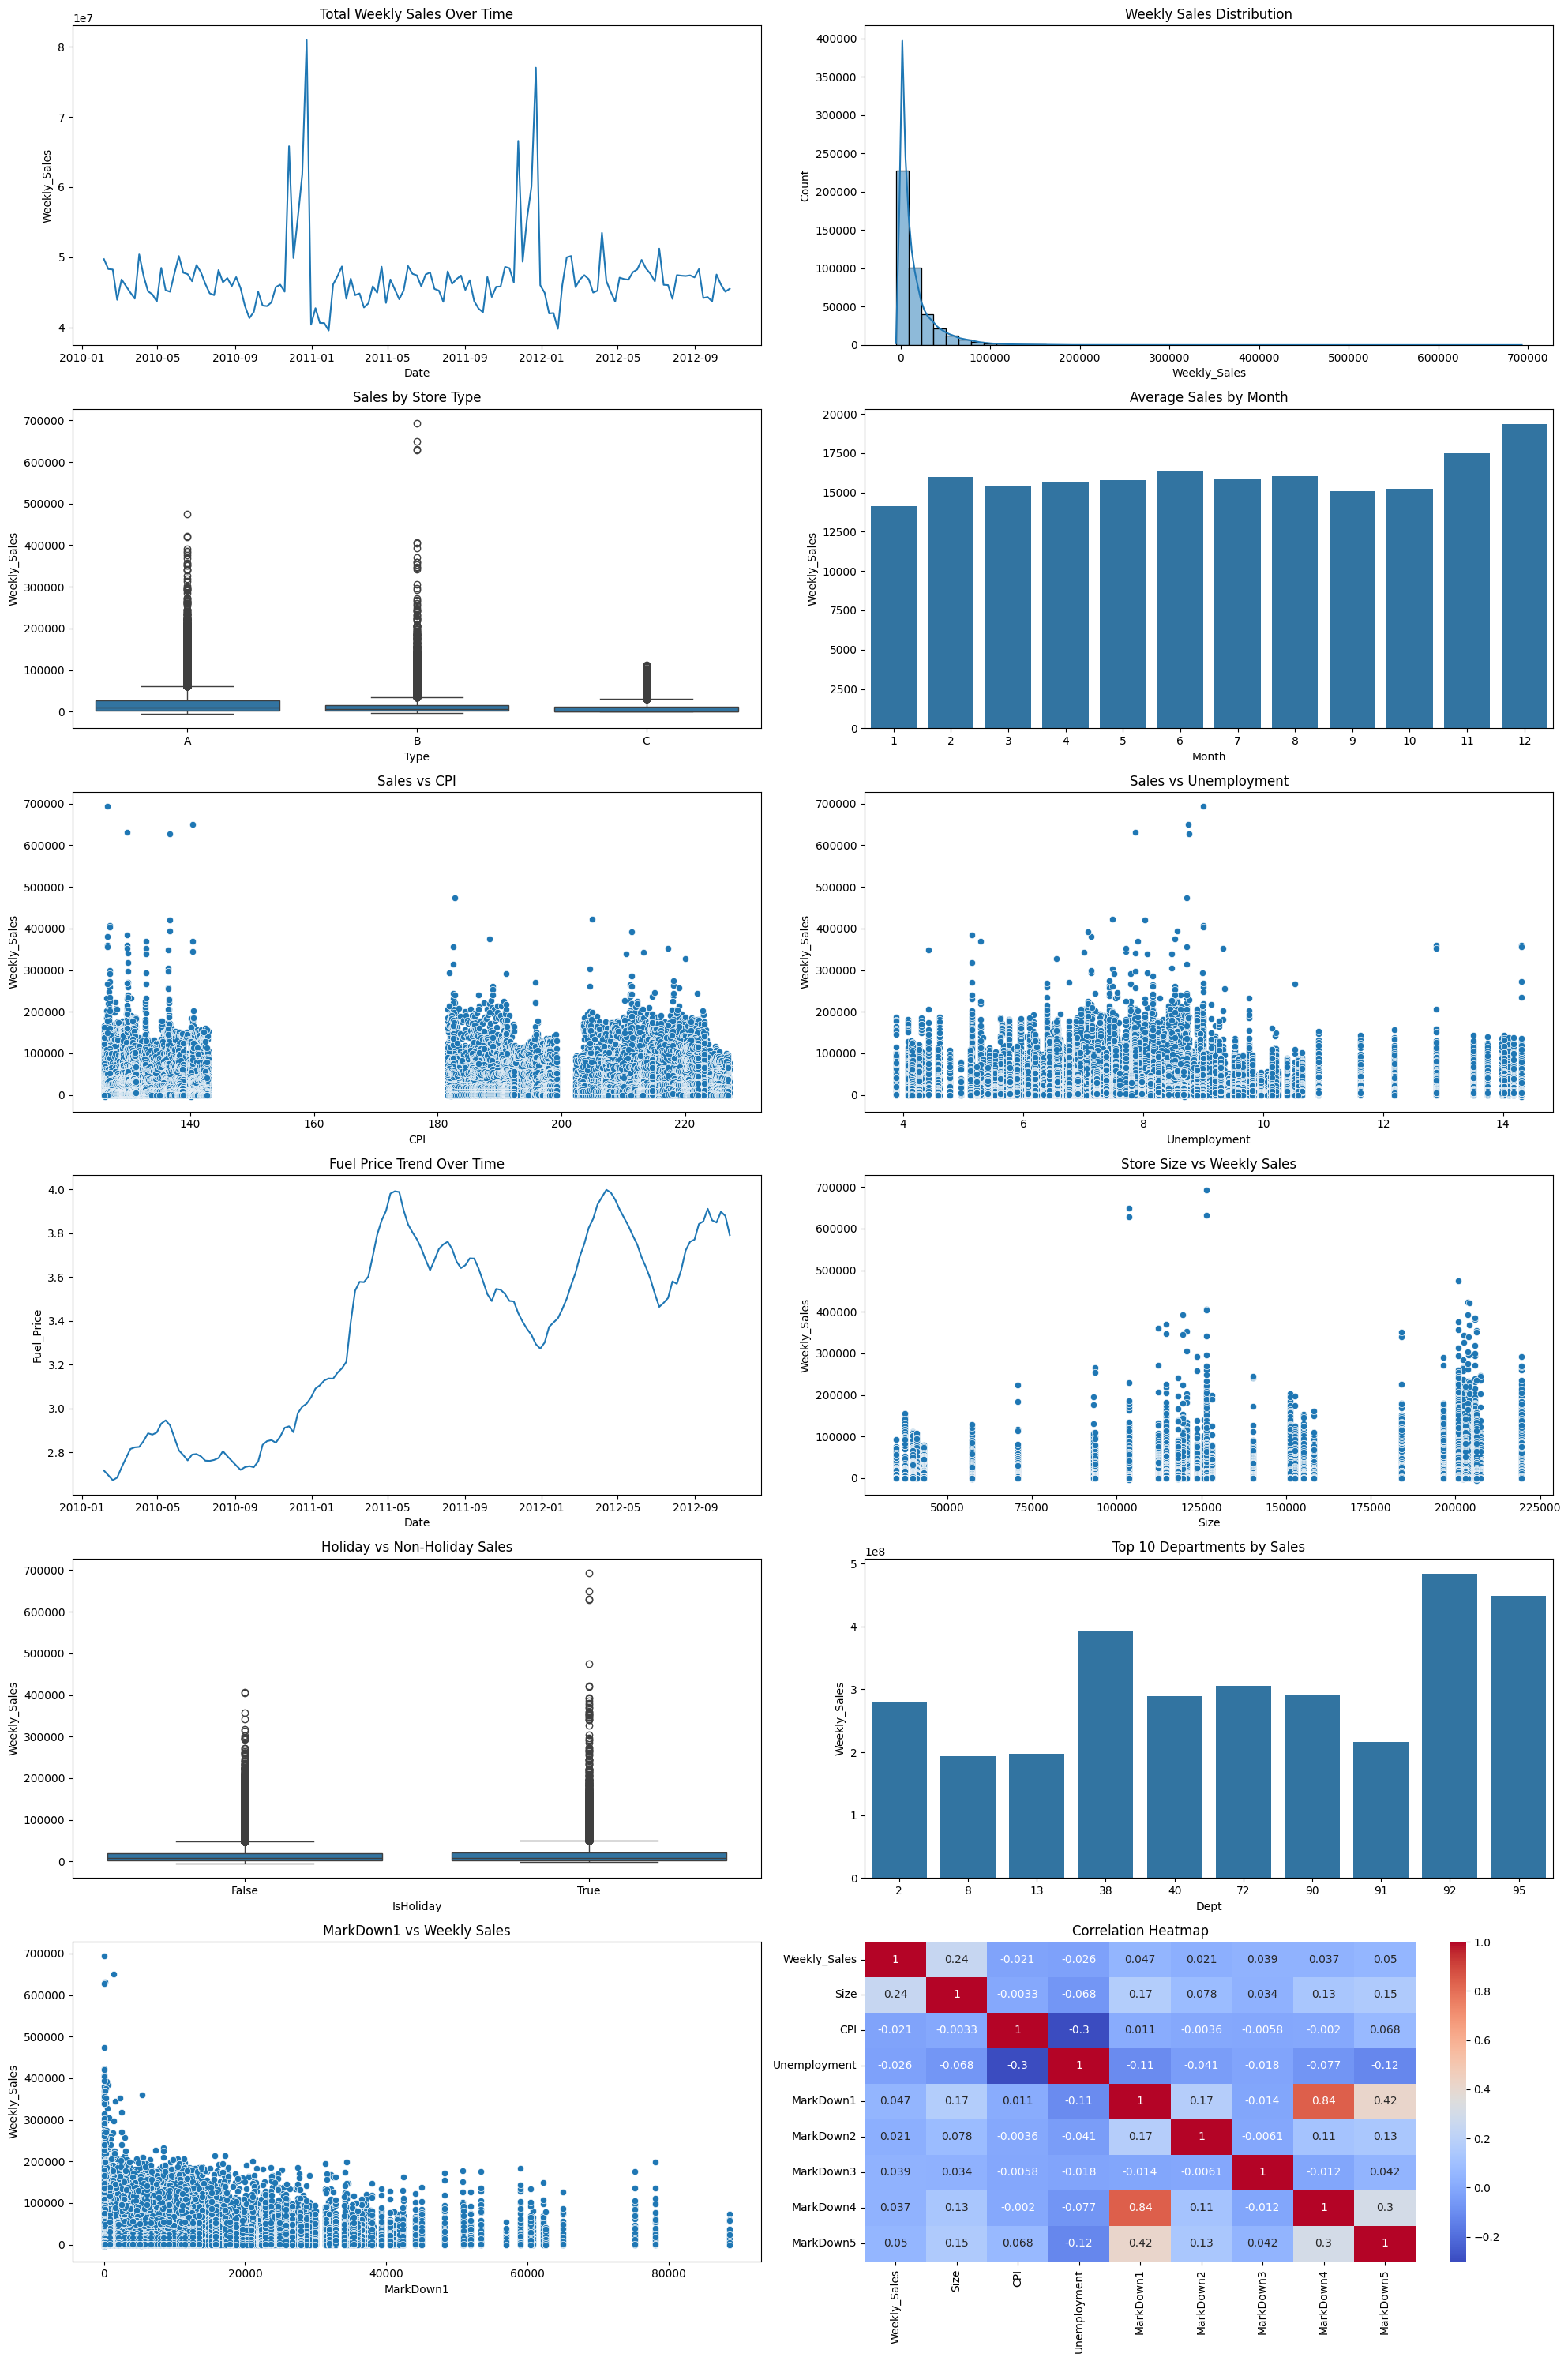

In [8]:
fig, axs = plt.subplots(6, 2, figsize=(20, 30))
axs = axs.flatten()

# 1. Total Weekly Sales Over Time
sns.lineplot(data=df.groupby('Date')['Weekly_Sales'].sum().reset_index(), x='Date', y='Weekly_Sales', ax=axs[0])
axs[0].set_title('Total Weekly Sales Over Time')

# 2. Sales Distribution
sns.histplot(df['Weekly_Sales'], bins=50, kde=True, ax=axs[1])
axs[1].set_title('Weekly Sales Distribution')

# 3. Sales by Store Type
sns.boxplot(data=df, x='Type', y='Weekly_Sales', ax=axs[2])
axs[2].set_title('Sales by Store Type')

# 4. Monthly Sales Pattern
monthly_avg = df.groupby('Month')['Weekly_Sales'].mean().reset_index()
sns.barplot(data=monthly_avg, x='Month', y='Weekly_Sales', ax=axs[3])
axs[3].set_title('Average Sales by Month')

# 5. Sales vs CPI
sns.scatterplot(data=df, x='CPI', y='Weekly_Sales', ax=axs[4])
axs[4].set_title('Sales vs CPI')

# 6. Sales vs Unemployment
sns.scatterplot(data=df, x='Unemployment', y='Weekly_Sales', ax=axs[5])
axs[5].set_title('Sales vs Unemployment')

# 7. Fuel Price Trend
sns.lineplot(data=df.groupby('Date')['Fuel_Price'].mean().reset_index(), x='Date', y='Fuel_Price', ax=axs[6])
axs[6].set_title('Fuel Price Trend Over Time')

# 8. Store Size vs Weekly Sales
sns.scatterplot(data=df, x='Size', y='Weekly_Sales', ax=axs[7])
axs[7].set_title('Store Size vs Weekly Sales')

# 9. Holiday vs Non-Holiday Sales
sns.boxplot(data=df, x='IsHoliday', y='Weekly_Sales', ax=axs[8])
axs[8].set_title('Holiday vs Non-Holiday Sales')

# 10. Top Departments by Total Sales
top_depts = df.groupby('Dept')['Weekly_Sales'].sum().reset_index().sort_values(by='Weekly_Sales', ascending=False)
sns.barplot(data=top_depts.head(10), x='Dept', y='Weekly_Sales', ax=axs[9])
axs[9].set_title('Top 10 Departments by Sales')

# 11. MarkDown1 vs Weekly Sales
sns.scatterplot(data=df, x='MarkDown1', y='Weekly_Sales', ax=axs[10])
axs[10].set_title('MarkDown1 vs Weekly Sales')

# 12. Correlation Heatmap
correlation_data = df[['Weekly_Sales', 'Size', 'CPI', 'Unemployment'] + markdowns]
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', ax=axs[11])
axs[11].set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

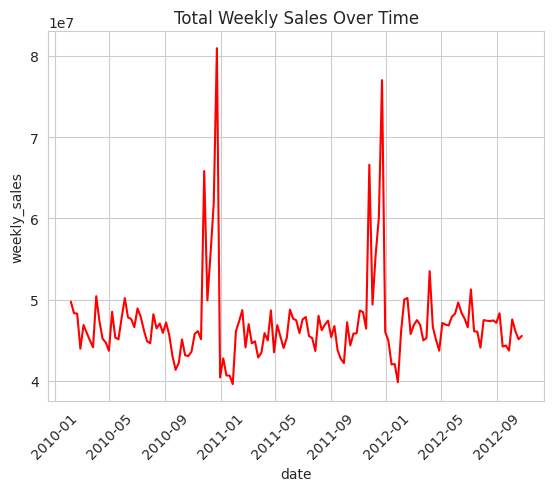

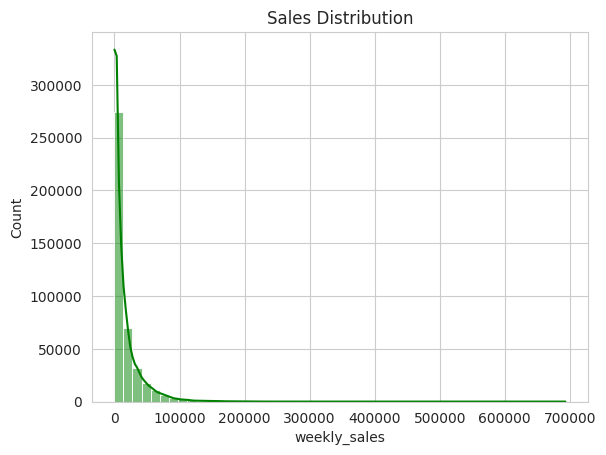

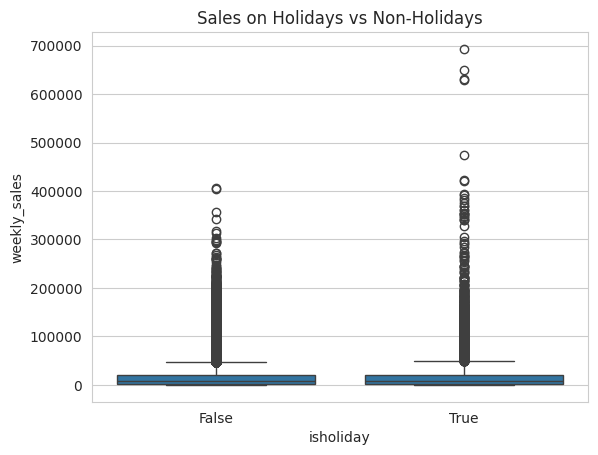

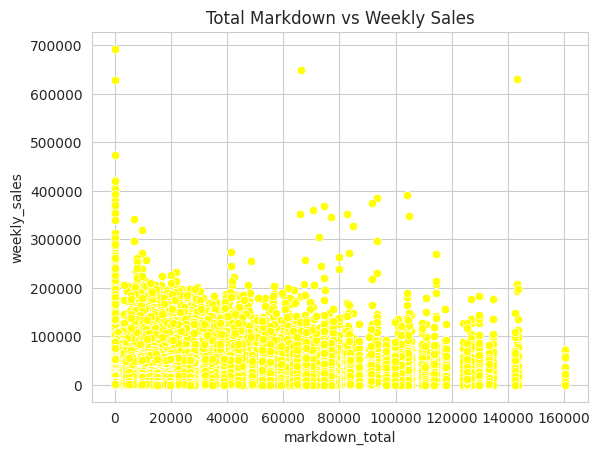

In [84]:
# 1. Sales Over Time (cleaned)
sns.set_style('whitegrid')
sales_over_time = df.groupby('date')['weekly_sales'].sum().reset_index()
sns.lineplot(data=sales_over_time, x='date', y='weekly_sales', color = 'red')
plt.title('Total Weekly Sales Over Time')
plt.xticks(rotation=45)
plt.show()

# 2. Sales Distribution
sns.histplot(df['weekly_sales'], bins=50, kde=True, color = 'green')
plt.title('Sales Distribution')
plt.show()

# 3. Sales by Holiday
sns.boxplot(x='isholiday', y='weekly_sales', data=df)
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

# 4. Markdown vs Sales
sns.scatterplot(x='markdown_total', y='weekly_sales', data=df, color = 'yellow')
plt.title('Total Markdown vs Weekly Sales')
plt.show()


In [85]:
df.head()

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,...,unemployment,type,size,month,week,year,is_weekend,quarter,markdown_total,sales_per_sqft
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,2,5,2010,False,1,0.0,0.164719
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,8.106,A,151315,2,6,2010,False,1,0.0,0.304263
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,8.106,A,151315,2,7,2010,False,1,0.0,0.274894
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,8.106,A,151315,2,8,2010,False,1,0.0,0.128233
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,8.106,A,151315,3,9,2010,False,1,0.0,0.144255


# **Customer Segmentation**

In [131]:
store_features = df.groupby('store').agg({
    'sales_per_sqft': 'mean',
    'markdown_total': 'mean',
    'size': 'first',
    'type': 'first'
}).reset_index()

store_features = pd.get_dummies(store_features, columns=['type'])

scaler = StandardScaler()
X = scaler.fit_transform(store_features.drop('store', axis=1))

kmeans = KMeans(n_clusters=3, random_state=42)
store_features['cluster'] = kmeans.fit_predict(X)

In [132]:
store_features.head()

,store,sales_per_sqft,markdown_total,size,type_A,type_B,type_C,cluster
0,1,0.143692,7330.043143,151315,True,False,False,2
1,2,0.133245,10035.003409,202307,True,False,False,2
2,3,0.170612,2461.637110,37392,False,True,False,0
3,4,0.141723,9695.166246,205863,True,False,False,2
4,5,0.145241,2923.587019,34875,False,True,False,0


<ipython-input-15-c8807440ddd0>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=store_features, x='cluster', palette='Set2', ax=axs[0, 1])


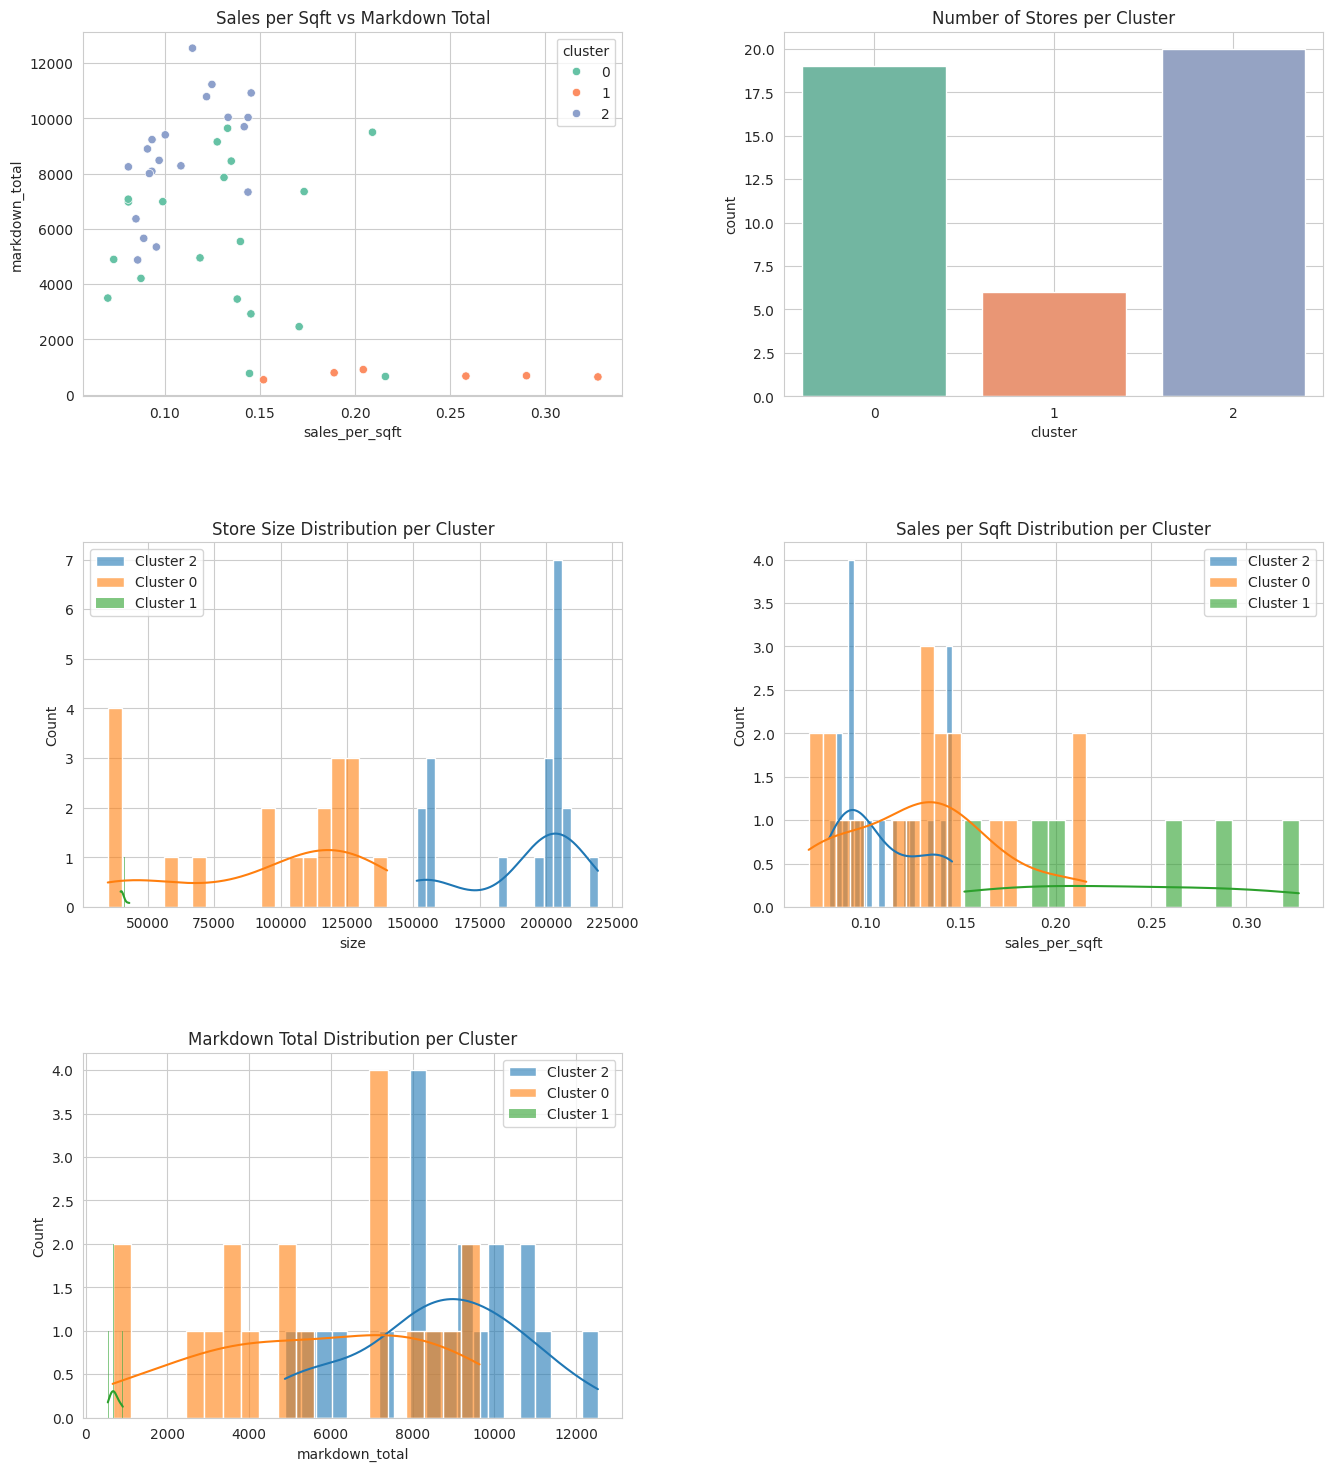

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(16, 18))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

sns.scatterplot(data=store_features, x='sales_per_sqft', y='markdown_total', hue='cluster', palette='Set2', ax=axs[0, 0])
axs[0, 0].set_title('Sales per Sqft vs Markdown Total')
axs[0, 0].grid(True)

sns.countplot(data=store_features, x='cluster', palette='Set2', ax=axs[0, 1])
axs[0, 1].set_title('Number of Stores per Cluster')
axs[0, 1].grid(True)

for cluster in store_features['cluster'].unique():
    sns.histplot(store_features[store_features['cluster'] == cluster]['size'], label=f'Cluster {cluster}', kde=True, ax=axs[1, 0], bins=20, alpha=0.6)
axs[1, 0].set_title('Store Size Distribution per Cluster')
axs[1, 0].legend()

for cluster in store_features['cluster'].unique():
    sns.histplot(store_features[store_features['cluster'] == cluster]['sales_per_sqft'], label=f'Cluster {cluster}', kde=True, ax=axs[1, 1], bins=20, alpha=0.6)
axs[1, 1].set_title('Sales per Sqft Distribution per Cluster')
axs[1, 1].legend()

for cluster in store_features['cluster'].unique():
    sns.histplot(store_features[store_features['cluster'] == cluster]['markdown_total'], label=f'Cluster {cluster}', kde=True, ax=axs[2, 0], bins=20, alpha=0.6)
axs[2, 0].set_title('Markdown Total Distribution per Cluster')
axs[2, 0].legend()

axs[2, 1].axis('off')

plt.show()

# **Anamoly Detection**

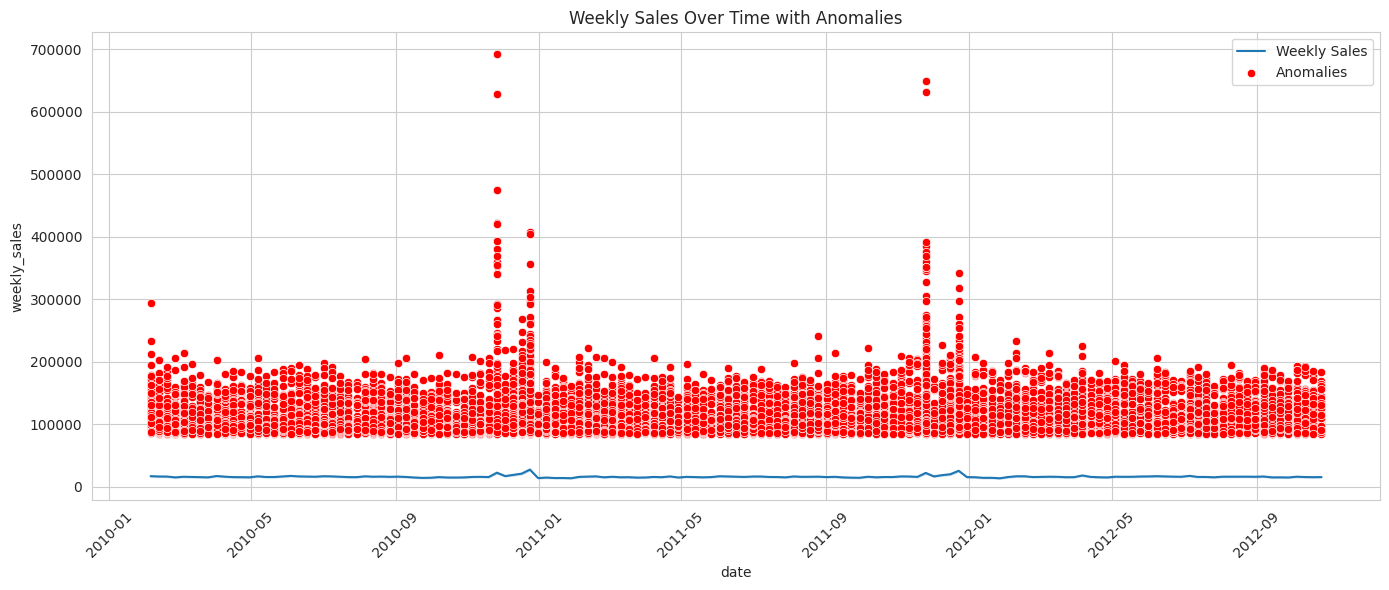

In [16]:
from scipy.stats import zscore
import numpy as np

df['z_score_sales'] = np.abs(zscore(df['weekly_sales']))
df['sales_anomaly'] = df['z_score_sales'] > 3

plt.figure(figsize=(14, 6))
sns.lineplot(x='date', y='weekly_sales', data=df, label='Weekly Sales')
sns.scatterplot(x='date', y='weekly_sales', data=df[df['sales_anomaly']], color='red', label='Anomalies')
plt.title('Weekly Sales Over Time with Anomalies')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
holiday_anomalies = df[df['sales_anomaly'] & df['isholiday']]
print(f"Holiday Anomalies Count: {len(holiday_anomalies)}")

Holiday Anomalies Count: 740


In [18]:
features_to_check = ['markdown_total', 'temperature', 'fuel_price', 'unemployment']
correlations = df[features_to_check + ['weekly_sales']].corr()['weekly_sales'].sort_values(ascending=False)
print("\nCorrelation with Weekly Sales:")
print(correlations)


Correlation with Weekly Sales:
weekly_sales      1.000000
markdown_total    0.065392
fuel_price        0.000092
temperature      -0.002333
unemployment     -0.025831
Name: weekly_sales, dtype: float64


In [19]:
from sklearn.ensemble import IsolationForest

features = ['weekly_sales', 'markdown_total', 'temperature', 'fuel_price', 'unemployment', 'sales_per_sqft']
X = df[features].fillna(0)

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['anomaly_ml'] = iso_forest.fit_predict(X)

In [20]:
df['anomaly_ml'] = df['anomaly_ml'].map({1: 0, -1: 1})

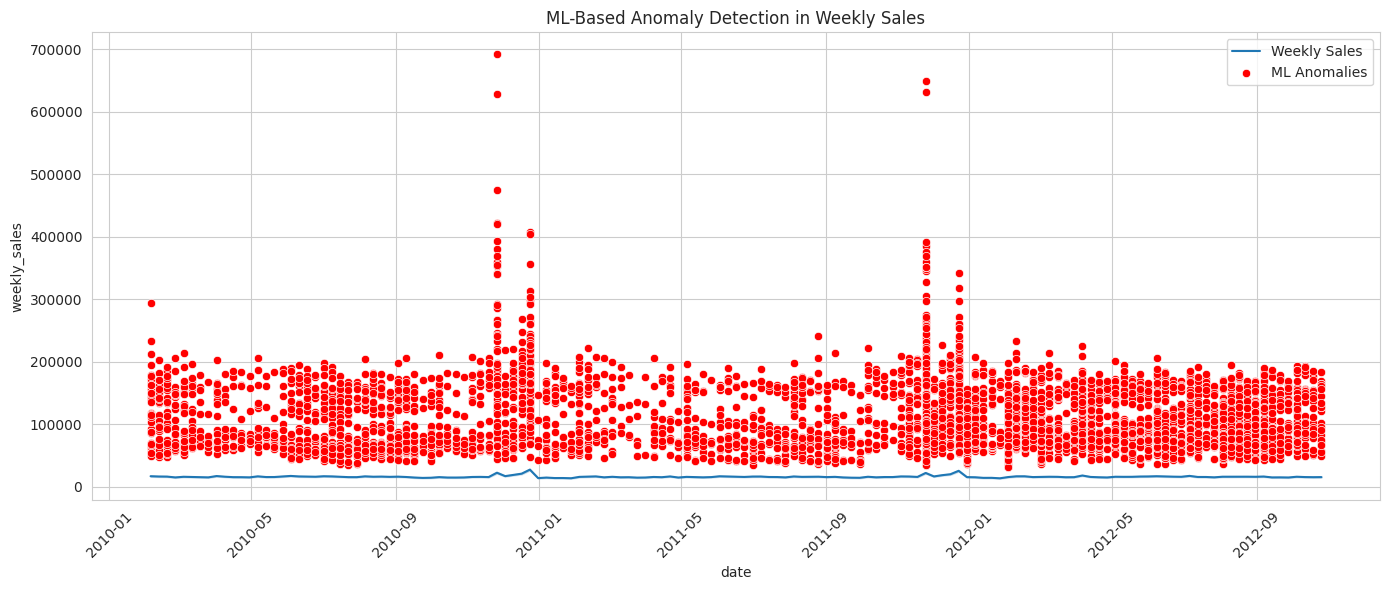

In [21]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='date', y='weekly_sales', data=df, label='Weekly Sales')
sns.scatterplot(x='date', y='weekly_sales', data=df[df['anomaly_ml'] == 1], color='red', label='ML Anomalies')
plt.title('ML-Based Anomaly Detection in Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
ml_anomalies = df[df['anomaly_ml'] == 1]
print(f"Total ML-based anomalies detected: {len(ml_anomalies)}")
print(ml_anomalies[['store', 'dept', 'date', 'weekly_sales', 'markdown_total']].head())

Total ML-based anomalies detected: 4203
      store  dept       date  weekly_sales  markdown_total
904       1     7 2010-12-24     166697.72            0.00
5222      1    38 2012-02-03      89029.26        76351.07
7689      1    72 2010-11-26     196810.42            0.00
7741      1    72 2011-11-25     203670.47        56876.74
9035      1    90 2011-11-25     107508.68        56876.74


Store Wise

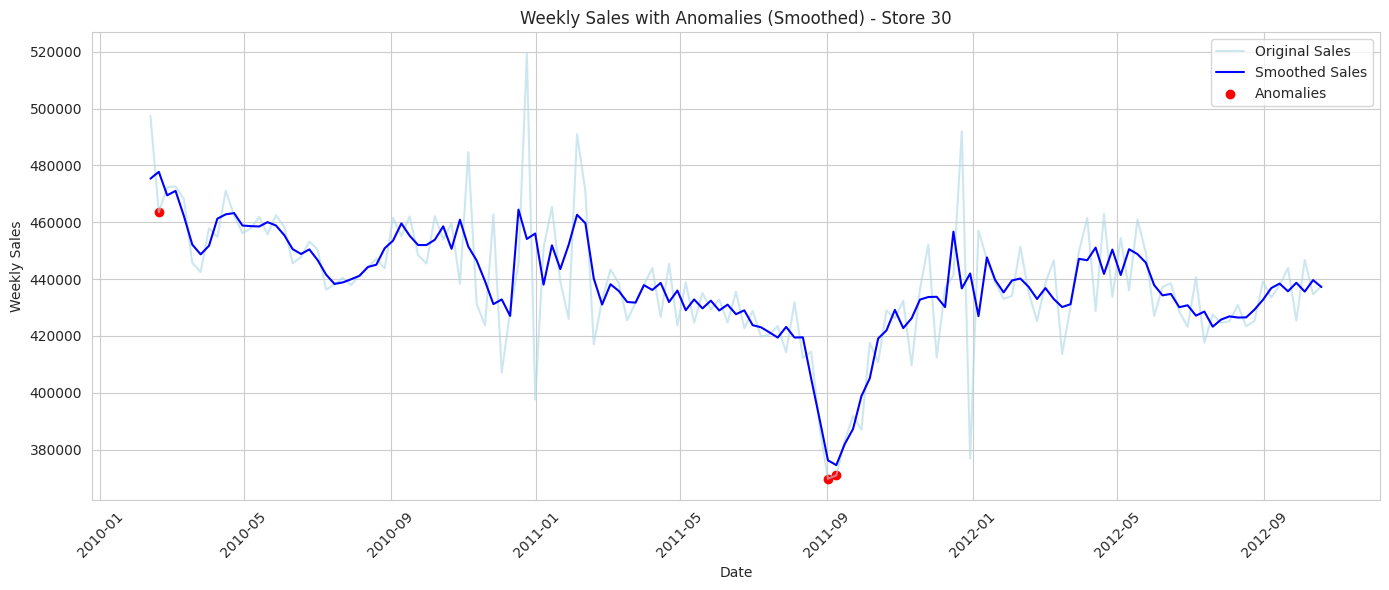

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

store_number = 30
store_df = df[df['store'] == store_number]

weekly_sales = store_df.groupby('date')['weekly_sales'].sum().reset_index()

weekly_sales['sales_smooth'] = weekly_sales['weekly_sales'].rolling(window=3, center=True).mean()
weekly_sales.dropna(inplace=True)

model = IsolationForest(contamination=0.02, n_estimators=200, random_state=42)
weekly_sales['anomaly'] = model.fit_predict(weekly_sales[['sales_smooth']])

anomalies = weekly_sales[weekly_sales['anomaly'] == -1]

plt.figure(figsize=(14, 6))
plt.plot(weekly_sales['date'], weekly_sales['weekly_sales'], label='Original Sales', color='lightblue', alpha=0.6)
plt.plot(weekly_sales['date'], weekly_sales['sales_smooth'], label='Smoothed Sales', color='blue')
plt.scatter(anomalies['date'], anomalies['weekly_sales'], color='red', label='Anomalies')
plt.title(f"Weekly Sales with Anomalies (Smoothed) - Store {store_number}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Time Based Anamoly detection**

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from scipy.stats import zscore

df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(['store', 'dept', 'date'])

In [41]:
from statsmodels.tsa.seasonal import STL
from scipy.stats import zscore
import numpy as np
import pandas as pd

def detect_anomalies(group, column='weekly_sales', z_thresh=3):
    series = group.set_index('date')[column].asfreq('W-FRI').ffill()

    # Skip small groups: STL needs at least 2 seasonal periods (2 * seasonal)
    if len(series.dropna()) < 26:  # 13 is default seasonal window
        group['trend'] = np.nan
        group['seasonal'] = np.nan
        group['resid'] = np.nan
        group['resid_z'] = np.nan
        group['anomaly'] = False
        return group

    try:
        stl = STL(series, seasonal=13, robust=True)
        res = stl.fit()
        stl_df = pd.DataFrame({
            'trend': res.trend,
            'seasonal': res.seasonal,
            'resid': res.resid,
            'resid_z': zscore(res.resid, nan_policy='omit')
        }, index=series.index)

        stl_df['anomaly'] = np.abs(stl_df['resid_z']) > z_thresh
        stl_df = stl_df.reset_index()
        group = group.merge(stl_df, on='date', how='left')
    except Exception as e:
        group['trend'] = np.nan
        group['seasonal'] = np.nan
        group['resid'] = np.nan
        group['resid_z'] = np.nan
        group['anomaly'] = False

    return group


In [42]:
results = df.groupby(['store', 'dept']).apply(detect_anomalies).reset_index(drop=True)


<ipython-input-42-61256e681c17>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby(['store', 'dept']).apply(detect_anomalies).reset_index(drop=True)


In [43]:
# Number of anomalies per store and department
anomaly_counts = results[results['anomaly']].groupby(['store', 'dept']).size().reset_index(name='anomaly_count')
anomaly_counts.sort_values(by='anomaly_count', ascending=False).head()


,store,dept,anomaly_count
460,7,41,9
1486,21,93,8
1842,26,93,8
2277,33,20,8
2898,43,18,8


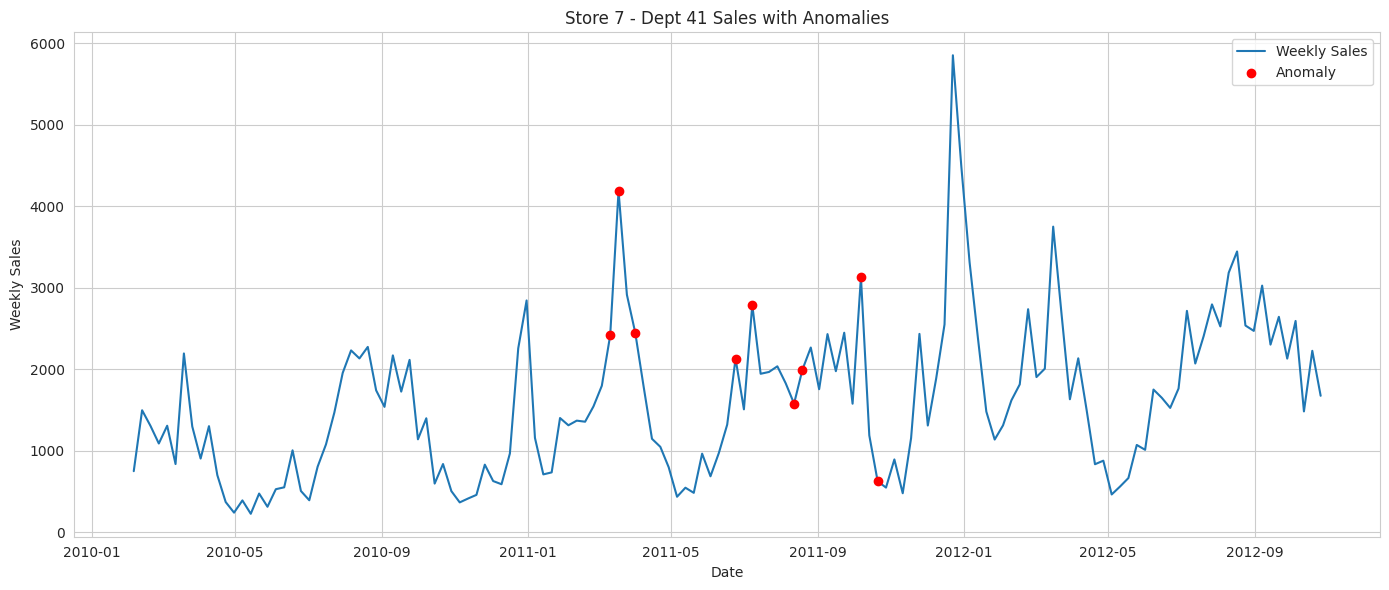

In [134]:
import matplotlib.pyplot as plt

store_id = 7
dept_id = 41

subset = results[(results['store'] == store_id) & (results['dept'] == dept_id)]

plt.figure(figsize=(14, 6))
plt.plot(subset['date'], subset['weekly_sales'], label='Weekly Sales')
plt.scatter(subset[subset['anomaly']]['date'], subset[subset['anomaly']]['weekly_sales'],
            color='red', label='Anomaly', zorder=5)
plt.title(f'Store {store_id} - Dept {dept_id} Sales with Anomalies')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Impact of Holiday in Anamolies

             count          mean           std   min        25%       50%  \
isholiday                                                                   
False      11964.0  16423.671694  22463.124870  0.00  2380.7350  7847.495   
True         744.0  18556.825484  27345.960518  1.97  3036.8625  9059.670   

                  75%        max  
isholiday                         
False      21138.6325  207824.62  
True       20624.0875  339846.03  


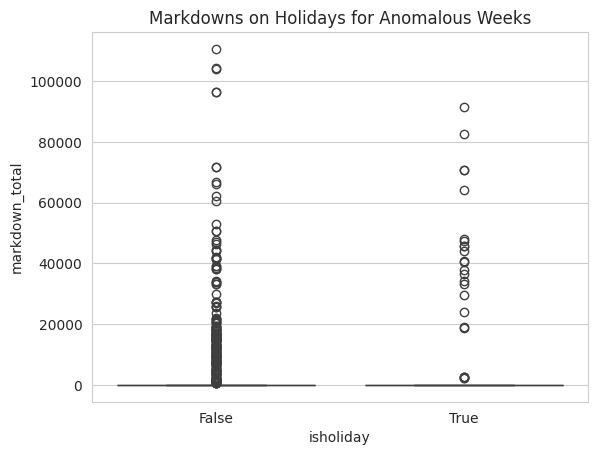

In [45]:
# Join holiday flag
anomalies = results[results['anomaly']]
anomalies_summary = anomalies.groupby('isholiday')['weekly_sales'].describe()
print(anomalies_summary)

sns.boxplot(data=anomalies, x='isholiday', y='markdown_total')
plt.title('Markdowns on Holidays for Anomalous Weeks')
plt.show()


# **Demand Forecasting**

In [104]:
df.sort_values(by=['store', 'dept', 'date'], inplace=True)

def create_lag_features(df, lags=[1, 2, 3], rolling_windows=[4]):
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(['store', 'dept'])['weekly_sales'].shift(lag)
    for window in rolling_windows:
        df[f'roll_mean_{window}'] = df.groupby(['store', 'dept'])['weekly_sales'].shift(1).rolling(window).mean()
    return df

df['weekofyear'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year


df = create_lag_features(df)


df.dropna(inplace=True)

feature_cols = [
    'lag_1', 'lag_2', 'lag_3', 'roll_mean_4',
    'temperature', 'fuel_price', 'cpi', 'unemployment',
    'markdown1', 'markdown2', 'markdown3', 'markdown4', 'markdown5',
    'size', 'month', 'weekofyear', 'year', 'isholiday'
]

X = df[feature_cols]
y = df['weekly_sales']

cutoff_date = '2012-09-01'
X_train = X[df['date'] < cutoff_date]
X_test = X[df['date'] >= cutoff_date]
y_train = y[df['date'] < cutoff_date]
y_test = y[df['date'] >= cutoff_date]


model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("MAE : ", mae)
print("RMSE : ", rmse)

MAE :  1410.8692140829571
RMSE :  3179.150793345469


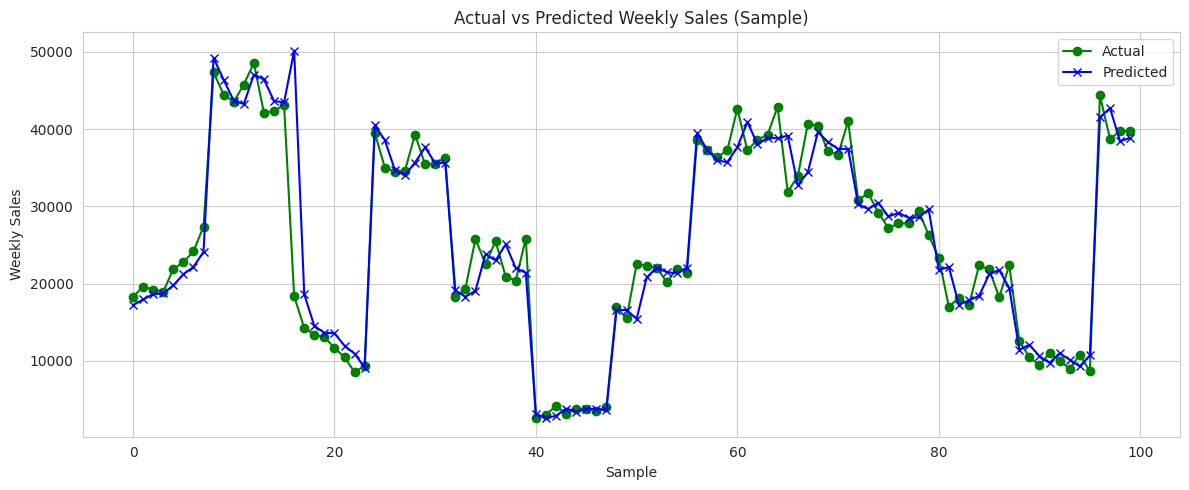

In [109]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual', marker='o', color = 'green')
plt.plot(y_pred[:100], label='Predicted', marker='x', color = 'blue')
plt.title('Actual vs Predicted Weekly Sales (Sample)')
plt.xlabel('Sample')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
future_weeks = 12
last_date = df['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=future_weeks, freq='W-FRI')

future_df = pd.DataFrame({'date': future_dates})
future_df['store'] = 1
future_df['dept'] = 1

In [61]:
future_df['month'] = future_df['date'].dt.month
future_df['week'] = future_df['date'].dt.isocalendar().week
future_df['quarter'] = future_df['date'].dt.quarter
future_df['isholiday'] = future_df['date'].isin(df[df['isholiday'] == 1]['date'].unique()).astype(int)

In [62]:
store_info = df[(df['store'] == 1) & (df['dept'] == 1)].iloc[-1]
future_df['size'] = store_info['size']

In [63]:
for col in ['fuel_price', 'cpi', 'unemployment', 'markdown1', 'markdown2','markdown3', 'markdown4', 'markdown5']:
  future_df[col] = store_info[col]

In [64]:
lag_source = df[(df['store'] == 1) & (df['dept'] == 1)].copy()
lag_source = lag_source.sort_values('date').reset_index(drop=True)

In [65]:
for lag in [1, 2, 3]:
  future_df[f'sales_lag_{lag}'] = lag_source['weekly_sales'].iloc[-lag]

In [67]:
future_df['rolling_mean_3'] = lag_source['weekly_sales'].iloc[-3:].mean()

future_features = ['fuel_price', 'cpi', 'unemployment', 'markdown1', 'markdown2', 'markdown3',
'markdown4', 'markdown5', 'isholiday', 'size', 'month', 'week', 'quarter',
'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'rolling_mean_3']

future_df['lag_1'] = future_df['sales_lag_1']
future_df['lag_2'] = future_df['sales_lag_2']
future_df['lag_3'] = future_df['sales_lag_3']
future_df['roll_mean_4'] = future_df['rolling_mean_3']
future_df['weekofyear'] = future_df['date'].dt.isocalendar().week
future_df['year'] = future_df['date'].dt.year
future_df['temperature'] = store_info['temperature']

drop_cols = ['sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'rolling_mean_3', 'week', 'quarter']
future_df = future_df.drop(columns=[col for col in drop_cols if col in future_df])


In [68]:
future_features = ['lag_1', 'lag_2', 'lag_3', 'roll_mean_4', 'temperature',
                   'fuel_price', 'cpi', 'unemployment', 'markdown1', 'markdown2',
                   'markdown3', 'markdown4', 'markdown5', 'size', 'month',
                   'weekofyear', 'year', 'isholiday']

future_df['predicted_sales'] = model.predict(future_df[future_features])


In [70]:
future_df.head()

,date,store,dept,month,isholiday,size,fuel_price,cpi,unemployment,markdown1,...,markdown4,markdown5,lag_1,lag_2,lag_3,roll_mean_4,weekofyear,year,temperature,predicted_sales
0,2012-11-02,1,1,11,0,151315,3.506,223.444251,6.573,2585.85,...,1057.16,1305.01,27390.81,24185.27,22764.01,24780.03,44,2012,69.16,27192.714844
1,2012-11-09,1,1,11,0,151315,3.506,223.444251,6.573,2585.85,...,1057.16,1305.01,27390.81,24185.27,22764.01,24780.03,45,2012,69.16,27192.714844
2,2012-11-16,1,1,11,0,151315,3.506,223.444251,6.573,2585.85,...,1057.16,1305.01,27390.81,24185.27,22764.01,24780.03,46,2012,69.16,26945.199219
3,2012-11-23,1,1,11,0,151315,3.506,223.444251,6.573,2585.85,...,1057.16,1305.01,27390.81,24185.27,22764.01,24780.03,47,2012,69.16,32530.923828
4,2012-11-30,1,1,11,0,151315,3.506,223.444251,6.573,2585.85,...,1057.16,1305.01,27390.81,24185.27,22764.01,24780.03,48,2012,69.16,32530.923828


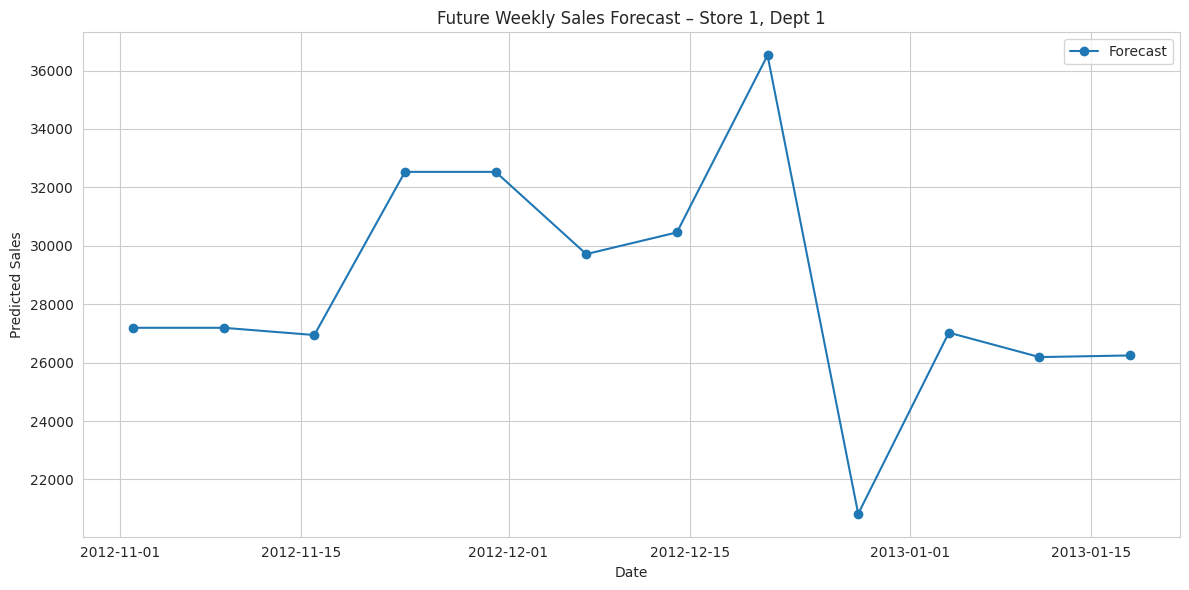

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(future_df['date'], future_df['predicted_sales'], marker='o', label='Forecast')
plt.title("Future Weekly Sales Forecast – Store 1, Dept 1")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()